In [ ]:
'''
Walmart — известная розничная корпорация, управляющая сетью гипермаркетов. Здесь Walmart предоставил данные по 45 магазинам, 
включая информацию о магазинах и ежемесячные продажи. Данные предоставляются еженедельно. Walmart пытается выяснить, 
как праздники влияют на продажи в магазине. 
Для этого в набор данных были включены четыре праздничные недели: Рождество, День Благодарения, Суперкубок, День труда. 
Здесь мы должны проанализировать предоставленный набор данных.
Прежде чем сделать это, позвольте мне указать на цель данного анализа.

Бизнес-цели
Наша основная задача — спрогнозировать продажи магазина за неделю. 
Как и в наборе данных, данные, связанные со временем и размером, представлены как характеристики, 
поэтому проанализируйте, влияют ли на продажи факторы, основанные на времени и факторе, основанном на пространстве. 
И самое главное, как включение праздников в неделю увеличивает продажи в магазине?
'''

In [1]:
import numpy as np      
import pandas as pd    
from pandas.plotting import autocorrelation_plot as auto_corr

# Для графиков
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

# Для date-time
import math
from datetime import datetime
from datetime import timedelta

# Другме необлодимые импорты
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Для увеличения просмотра колонок

pd.options.display.max_columns=100

In [2]:
df_store = pd.read_csv('stores_02.csv')
df_train = pd.read_csv('train_02.csv')
df_features = pd.read_csv('features_02.csv')

In [3]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
# Объединим три датасета

df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [7]:
# Удаоим дублирующую колону

df.drop(['IsHoliday_y'], axis=1,inplace=True) 

# переименовываем колонку

df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) 

df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [8]:
df.shape

(421570, 16)

In [ ]:
'''
Номера магазинов и отделов
'''

In [9]:
# количество различных значений

df['Store'].nunique()

45

In [10]:
df['Dept'].nunique()

81

In [ ]:
'''
Посмотрим на средние еженедельные продажи для каждого магазина и каждого отдела - 
есть ли какие-то странные значения или нет. 
Имеется 45 магазинов и 81 отдел для магазинов.
'''

In [11]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN
6,23867.553776,50269.437273,16806.638811,34187.366503,34465.307622,7225.566643,34526.870420,47577.719790,48271.060140,47436.477902,...,53715.366084,45270.405175,99024.796503,41359.651189,41701.693497,89208.786294,30450.542238,20637.667063,9728.100629,388.636750
7,9542.801259,22603.690769,8633.536923,14950.518601,13860.350490,6329.928811,10925.757063,13970.619371,29722.736084,21136.560280,...,13858.405874,10263.880000,26530.890559,1328.178252,699.332522,34208.097273,1123.383217,4374.927902,260.886596,15.000000
8,14789.827343,35729.821748,10683.305105,21089.309301,19838.849231,3395.425455,20268.743776,26438.524336,11792.661678,20666.433776,...,39333.566154,31530.560909,60465.630000,27515.635315,25442.578042,62951.463706,16.986667,16978.366503,6880.466434,298.153714
9,11846.558252,24969.477413,7497.356783,17165.947762,19282.746014,2806.416364,13826.694336,21424.470699,13196.569720,12810.480350,...,2981.249510,869.273287,14123.063147,21.240000,599.112568,29575.050769,3596.107762,372.655556,27.930000,NaN


In [ ]:
'''
Номера магазинов начинаются с 1 по 45, номера отделов — с 1 по 99, но некоторые цифры отсутствуют, 
например, нет 88 или 89 и т. д. Общее количество отделов — 81.

Из сводной таблицы очевидно, что есть некоторые неправильные значения, например, значения 0 и минус для еженедельных продаж. 
Но сумма продаж не может быть минусовой. Также невозможно, чтобы один отдел целую неделю ничего не продавал.
'''

In [13]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


In [14]:
df = df.loc[df['Weekly_Sales'] > 0]
df.shape

(420212, 16)

In [ ]:
'''
Даты
'''

In [15]:
# Посмотрим на пять первы и пять последних дат.

df['Date'].head()


0    2010-02-05
1    2010-02-05
2    2010-02-05
3    2010-02-05
4    2010-02-05
Name: Date, dtype: object

In [16]:
df['Date'].tail()

421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

In [ ]:
'''
Даты начинаются с 5 февраля 2010, заканчиваются 26 октября 2012.
'''

In [ ]:
'''
Колонка IsHoliday
'''

<AxesSubplot:xlabel='IsHoliday', ylabel='Weekly_Sales'>

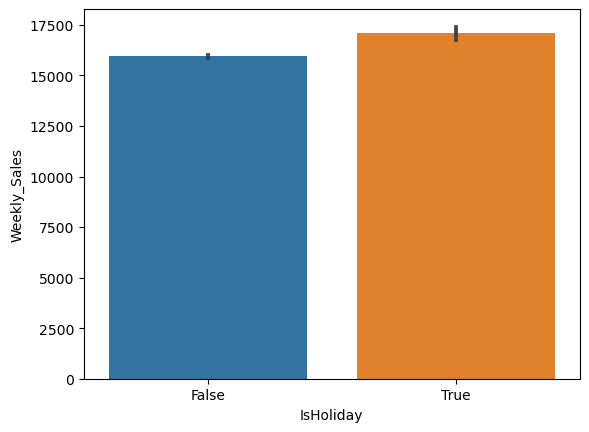

In [17]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [18]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique() 

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [19]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique() 

133

In [ ]:
'''
В данных отсутствуют все праздники. Есть 4 праздничных значения, таких как;

Суперкубок: 12 февраля 10, 11 февраля 11, 10 февраля 12, 8 февраля 13.

День труда: 10 сентября 10 года, 9 сентября 11 года, 7 сентября 2012 года, 6 сентября 2013 года.

День Благодарения: 26 ноября 10 года, 25 ноября 11 ноября, 23 ноября 2012 года, 29 ноября 2013 года.

Рождество: 31 декабря 10, 30 декабря 11, 28 декабря 12, 27 декабря 13 года.

После 07 сентября 2012 г. праздники находятся в тестовом наборе для прогнозирования. Когда мы смотрим на данные, 
средние еженедельные продажи в праздничные дни значительно выше, чем в непраздничные дни. 
В данных о поездах 133 недели непраздничных дней и 10 недель отпускных.

Посмотрим различия между типами отдыха. Создадим новые столбцы для четырех типов праздников и заполняю их логическими значениями. 
Если дата относится к этому типу праздника, она имеет значение True.
'''

In [20]:
# Даты Суперкубка в датасете

df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [21]:
# Даты Дня Труда в датасете

df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [22]:
# Даты Дня благодарения в датасете

df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [23]:
# Даты Рождества в датасете

df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

<AxesSubplot:xlabel='Christmas', ylabel='Weekly_Sales'>

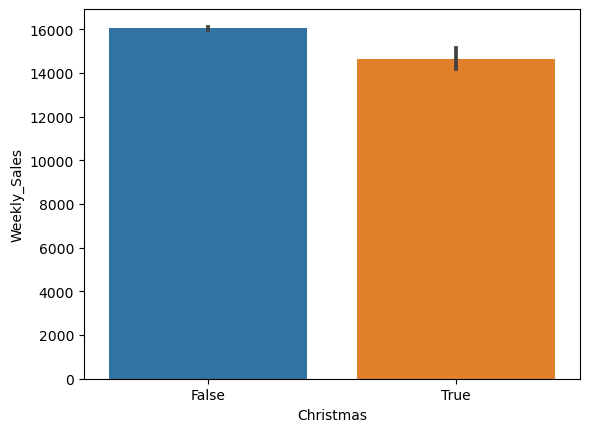

In [23]:
# Рождественские выходные против не-выходных

sns.barplot(x='Christmas', y='Weekly_Sales', data=df) 

<AxesSubplot:xlabel='Thanksgiving', ylabel='Weekly_Sales'>

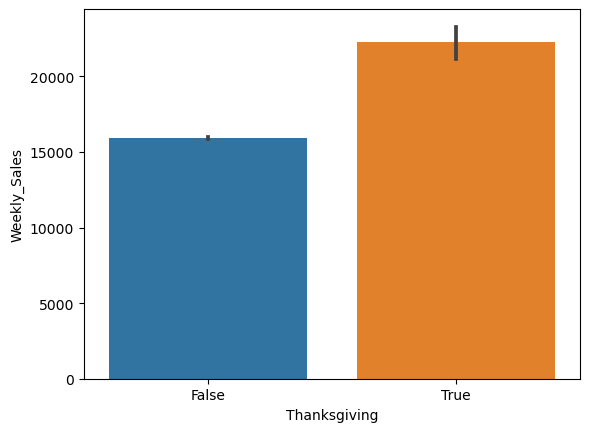

In [24]:
# Выходные Дня благодарения против невыходных

sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df) 

<AxesSubplot:xlabel='Super_Bowl', ylabel='Weekly_Sales'>

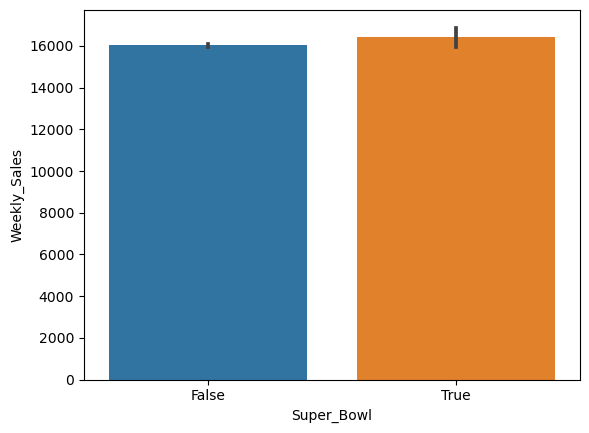

In [25]:
# Выходные Суперкубка против невыходных

sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df) 

<AxesSubplot:xlabel='Labor_Day', ylabel='Weekly_Sales'>

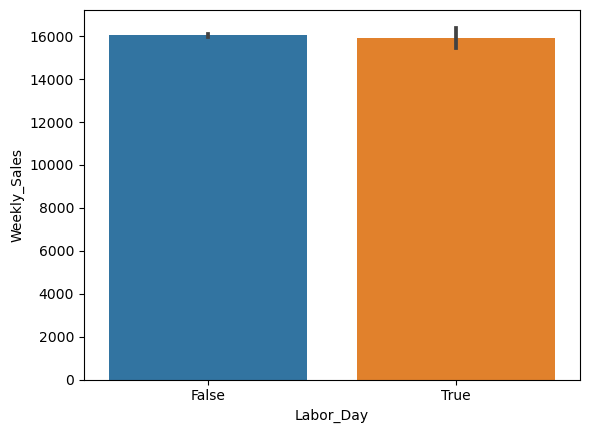

In [26]:
# Выходные Дня Труда против невыходных

sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df) 

In [ ]:
'''
Показано, что на графиках День труда и Рождество не увеличивают средние еженедельные продажи. 
Положительное влияние на продажи наблюдается в Суперкубке, но наибольшая разница приходится на День Благодарения. 
Предполагаем, что люди обычно предпочитают покупать рождественские подарки за 1-2 недели до Рождества, 
поэтому продажи на рождественской неделе не меняются. А на неделе Благодарения проходят распродажи в Черную пятницу.
'''

In [ ]:
'''
Влияние на праздники
В данных есть три разных типа магазинов: A, B и C.
'''

In [27]:
# Средние еженедельные продажи типов на Рождество

df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()   

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [28]:
# Средние еженедельные продажи типов на День Труда

df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [29]:
# Средние еженедельные продажи типов на День Благодарения

df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean() 

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [30]:
# Средние еженедельные продажи типов на ДСуперкубок

df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

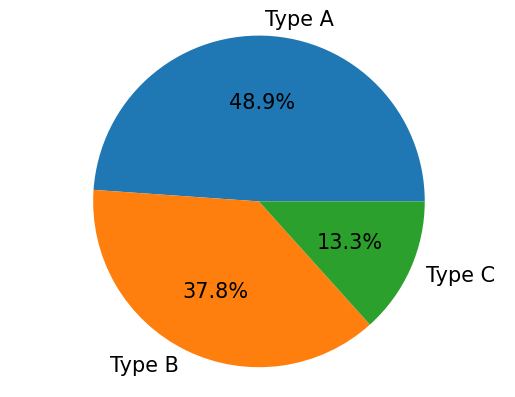

In [31]:
# Посмотрим процентное соотношение типов магазинов.

# Проценты
my_data = [48.88, 37.77 , 13.33 ]  

# Лэйблы
my_labels = 'Type A','Type B', 'Type C' 
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')
mpl.rcParams.update({'font.size': 20})

plt.show()

In [32]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

In [ ]:
'''
Почти половина магазинов относится к типу А.
'''

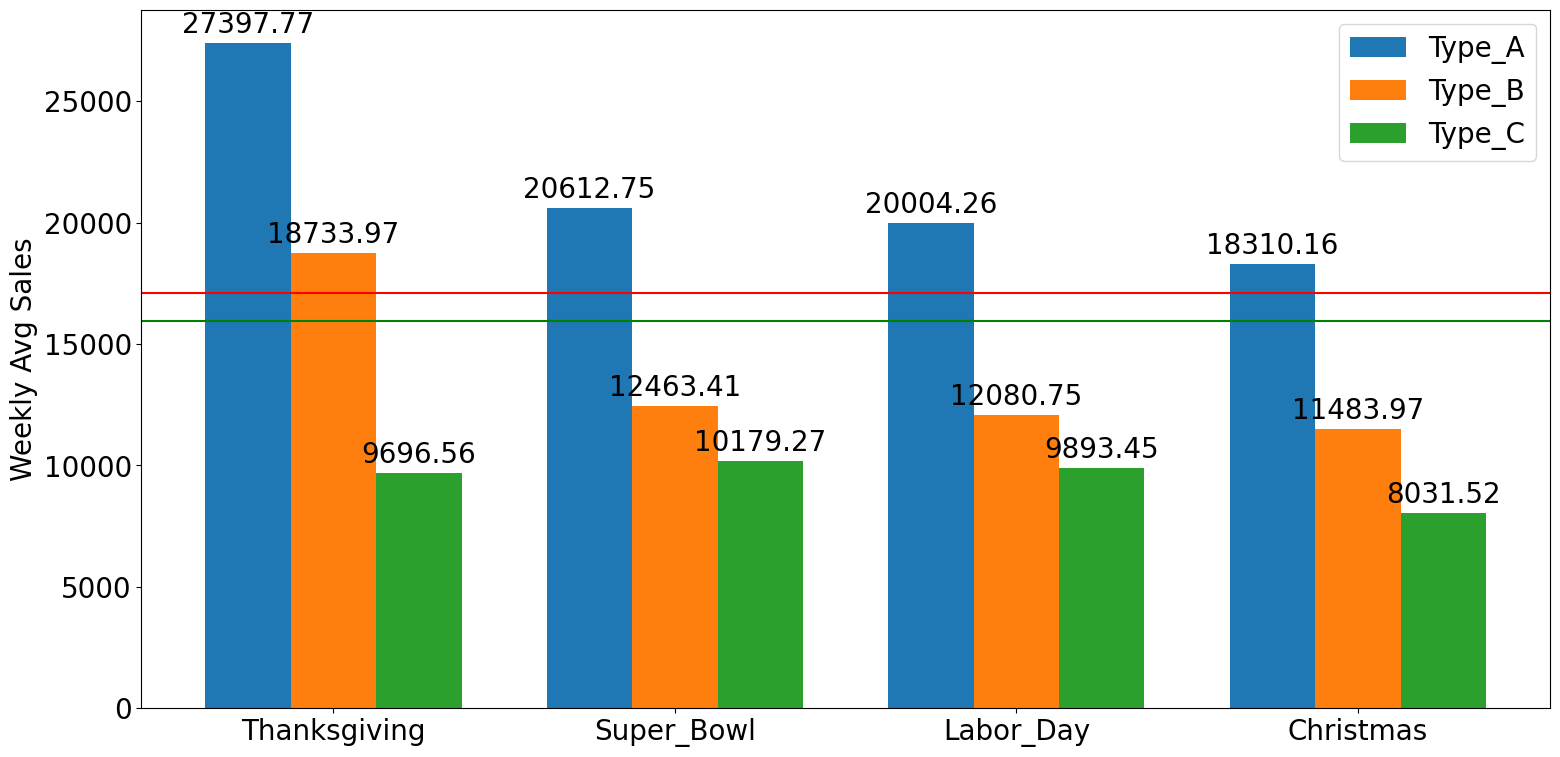

In [33]:
# Построение средних еженедельных продаж по праздникам по типам

labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Добавим текст для меток, заголовка, пользовательских меток делений по оси X и т. д.

ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    # Прикрепим текстовую метку над каждой полосой в *rects*, отображающую ее высоту.
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Вертикальное смещение на 3 точки
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # праздники в среднем
plt.axhline(y=15952.82,color='green') # непраздники в среднем

fig.tight_layout()

plt.show()

In [ ]:
'''
Из графика видно, что самый высокий средний показатель продаж приходится на неделю Дня благодарения между праздниками. 
И за все праздники в магазинах типа А самые высокие продажи.
'''

In [34]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
90645,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
337053,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
94393,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
333594,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
131088,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


In [ ]:
'''
Пятерка самых высоких еженедельных продаж приходится на недели Благодарения.
'''

In [ ]:
'''
Посмотрим соотношение размера и типа
'''

In [35]:
df_store.groupby('Type').describe()['Size'].round(2)

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


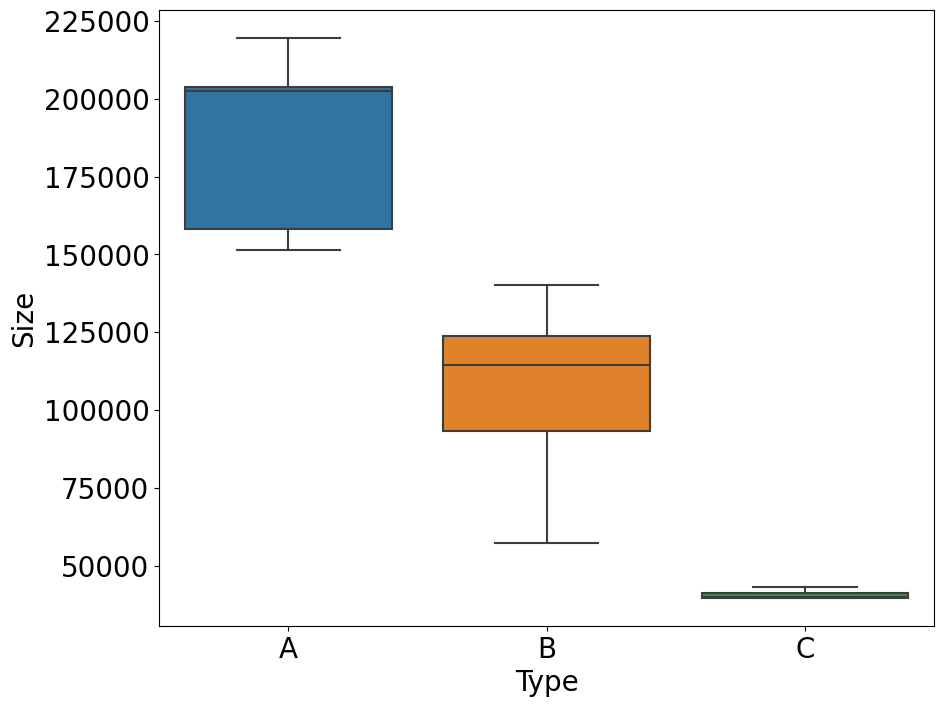

In [36]:
plt.figure(figsize=(10,8)) 
# Соотношение типа и размера
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers=False)

In [ ]:
'''
Как и ожидалось, размер магазинов такого типа соответствует объему продаж. В магазинах большего размера продажи выше. 
А Walmart классифицирует магазины по их размерам в соответствии с графиком. 
После наименьшего значения размера типа A начинается тип B. После наименьшего значения размера типа B начинается тип C.
'''

In [ ]:
'''
Столбцы уценки
Walmart предоставил столбцы скидок, чтобы увидеть эффект от скидок на продажи. 
Когда я проверяю столбцы, есть много значений NaN для уценок. 
Я решил поменять их на 0, потому что если в строке есть уценка, то она отображается цифрами. 
Итак, если я могу написать 0, это показывает, что на эту дату уценка отсутствует.
'''

In [36]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [37]:
# Заменим nan на 0

df = df.fillna(0) 

In [38]:
# Проверим

df.isna().sum() 

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [39]:
# Посмотрим статистику

df.describe() 

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [ ]:
'''
Минимальное значение для еженедельных продаж — 0,01. Скорее всего, это значение неверно, но я предпочитаю не менять их сейчас. 
Потому что здесь много отделов и много магазинов. 
Проверка каждого отдела каждого магазина занимает слишком много времени (45 магазинов на 81 отдел). 
Итак, я беру средние значения для EDA.
'''

In [ ]:
'''
Более глубокий взгляд на продажи
'''

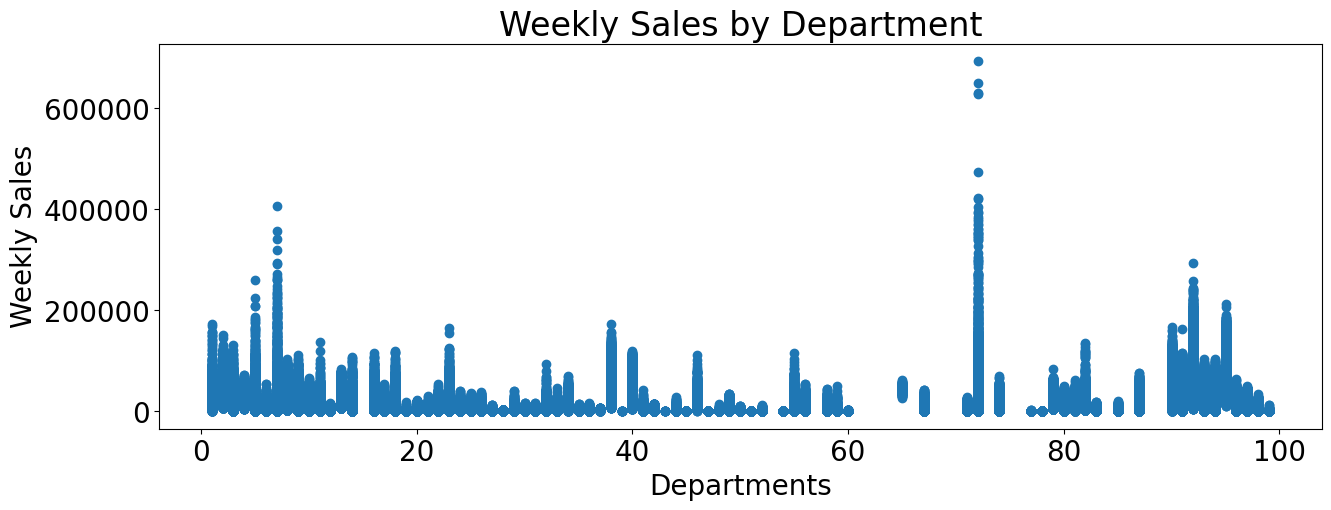

In [40]:
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

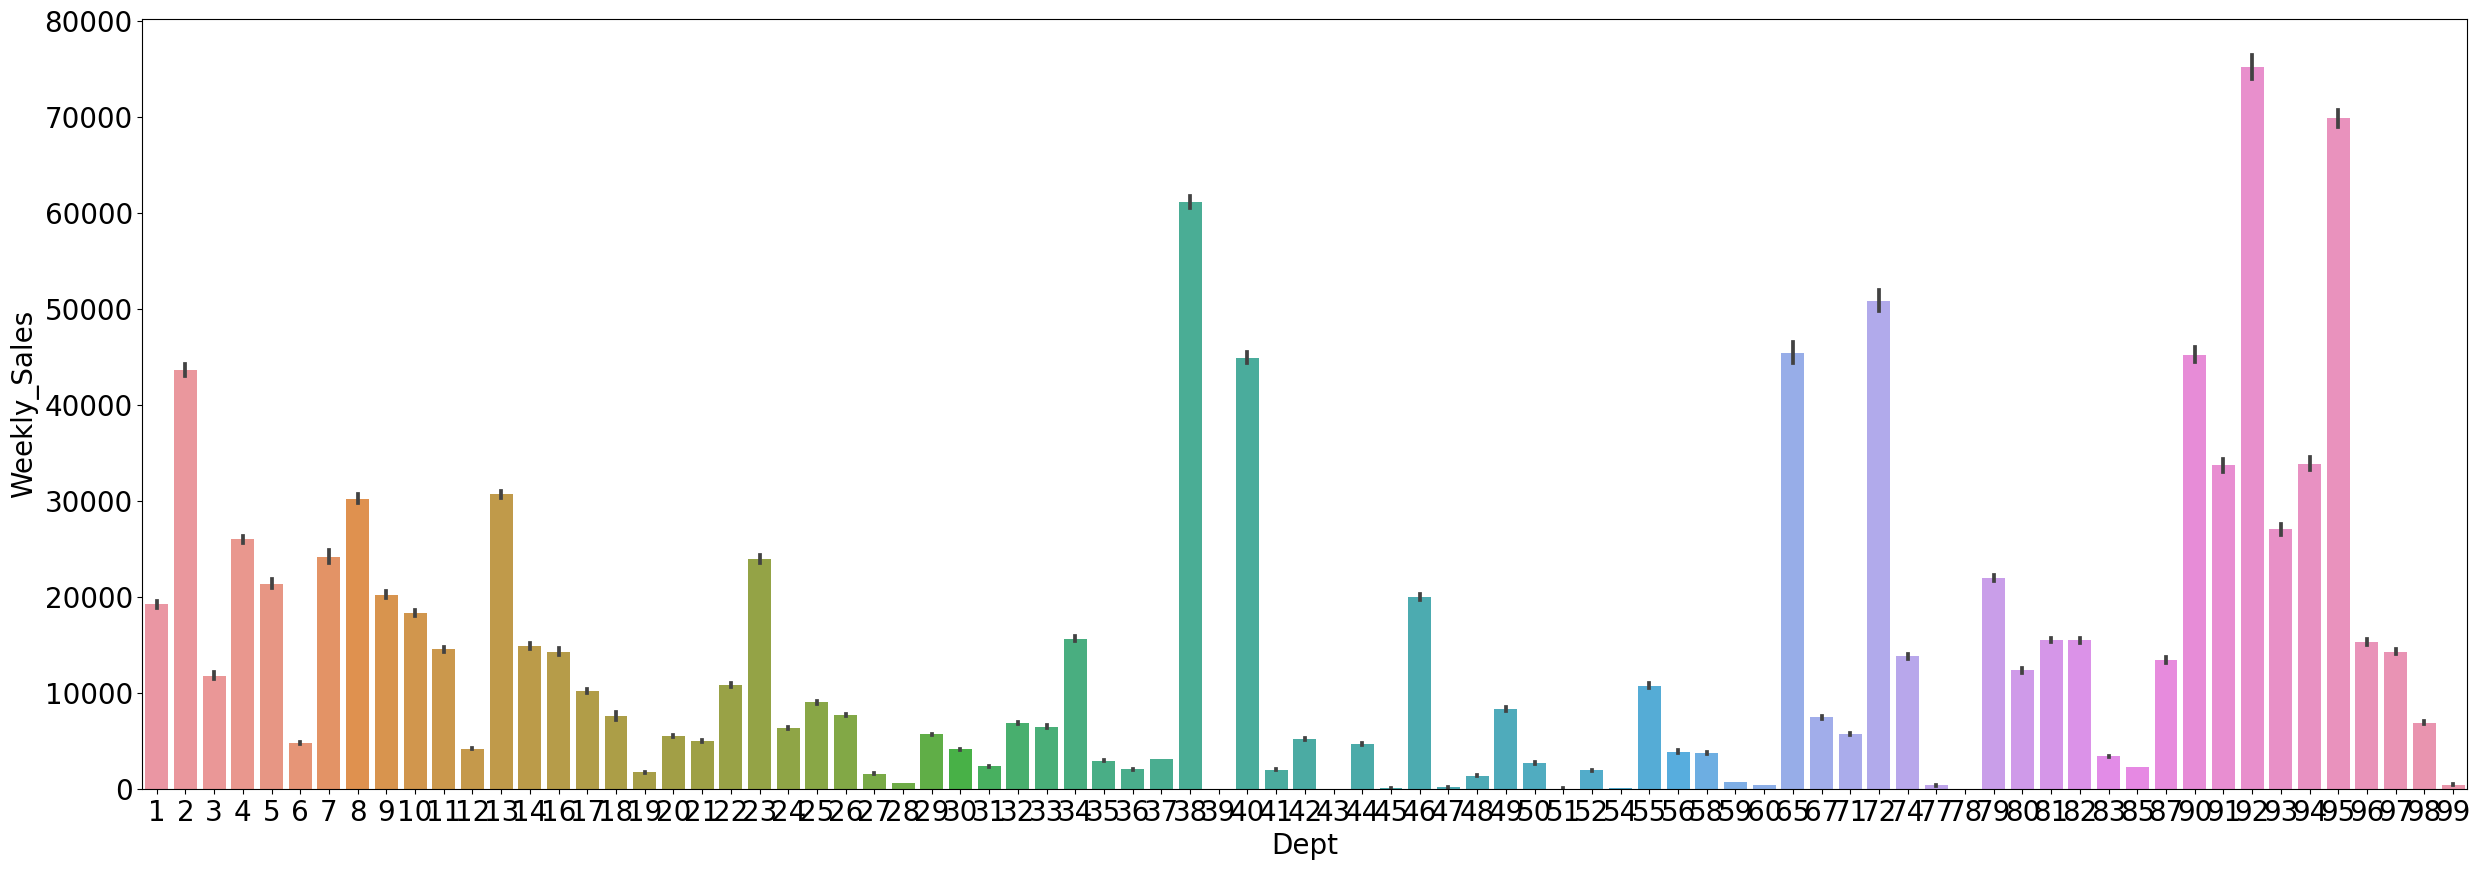

In [41]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)

In [ ]:
'''
Из первого графика видно, что один отдел между 60-80 (я предполагаю, что это 72) имеет более высокие показатели продаж. 
Но если мы возьмем средние значения, то увидим, что отдел 92 имеет более высокие средние продажи. 
Думаю, отдел 72 — сезонный. В некоторые сезоны он имеет более высокие значения, но в среднем 92 выше.
'''

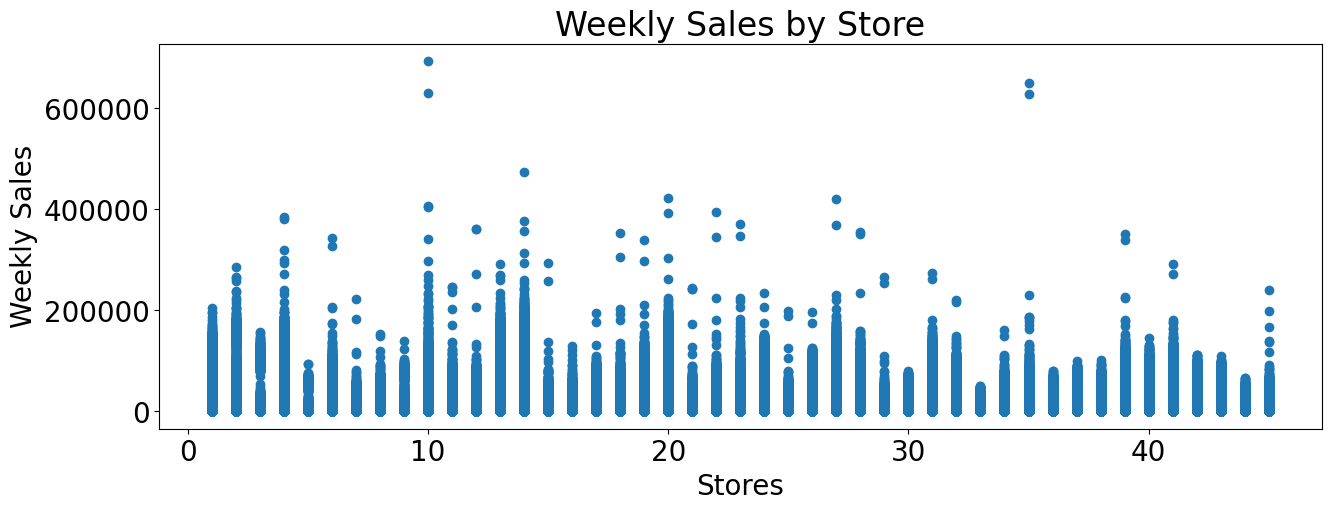

In [42]:
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

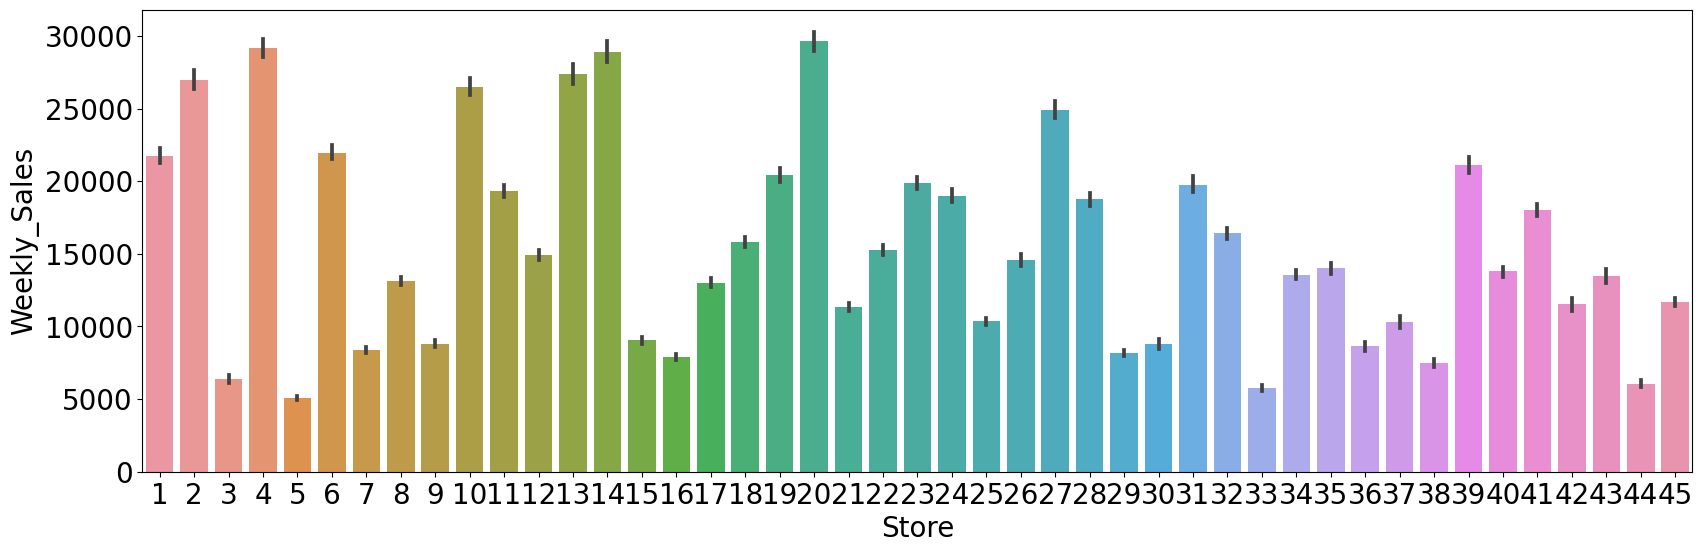

In [44]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

In [ ]:
'''
То же самое происходит и в магазинах. 
Судя по первому графику, в некоторых магазинах продажи выше, но в среднем 20-й магазин является лучшим, а за ним следуют 4-й и 14-й.
'''

In [ ]:
'''
Изменение Date на Datetime и создание новых столбцов.
'''

In [43]:
df['Date'] = pd.to_datetime(df['Date'])
df['week'] = df['Date'].dt.week
df['month'] = df['Date'].dt.month 
df['year'] = df['Date'].dt.year

In [44]:
# Лучшая месячная касса

df.groupby('month')['Weekly_Sales'].mean() 

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [45]:
# Лучшая годовая касса

df.groupby('year')['Weekly_Sales'].mean() 

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<AxesSubplot:xlabel='month'>

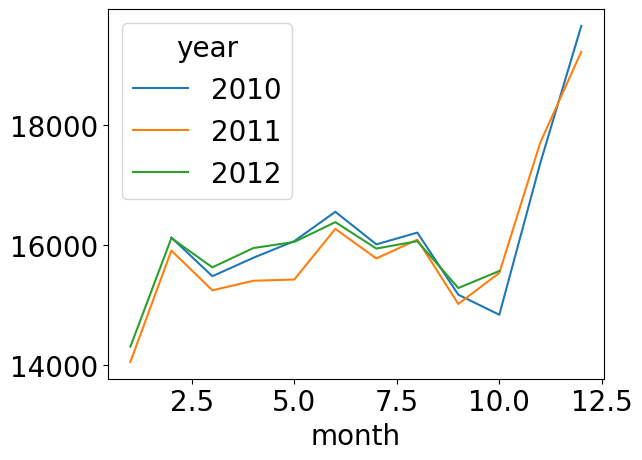

In [46]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

In [ ]:
'''
Из графика видно, что в 2011 году продажи были ниже, чем в 2010 году в целом. 
Когда мы смотрим на средние продажи, видно, что в 2010 году значения выше, но в 2012 году нет информации о ноябре и декабре, 
в которых продажи выше. 
Несмотря на то, что в 2012 году продаж за последние два месяца не было, это означает, что это близко к 2010 году. 
Скорее всего, он займет первое место, если мы получим результаты 2012 года и сложим их.
'''

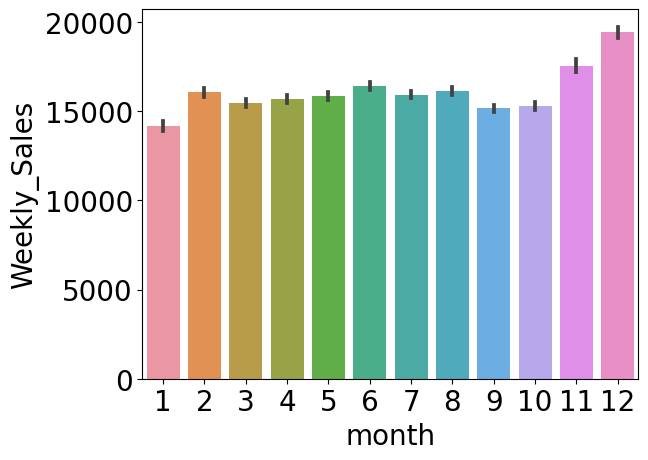

In [47]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

In [ ]:
'''
Если посмотреть на график выше, как и ожидалось, лучшие продажи приходятся на декабрь и ноябрь. 
Самые высокие значения относятся к празднику Дня благодарения, но если взять среднее значение, становится очевидным, 
что декабрь имеет лучшее значение.
'''

In [48]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

In [ ]:
'''
Топ-5 средних продаж за неделю приходится на 1-2 недели перед Рождеством, Днем Благодарения, Черной пятницей и концом мая, 
когда школы закрыты.
'''

<AxesSubplot:xlabel='week'>

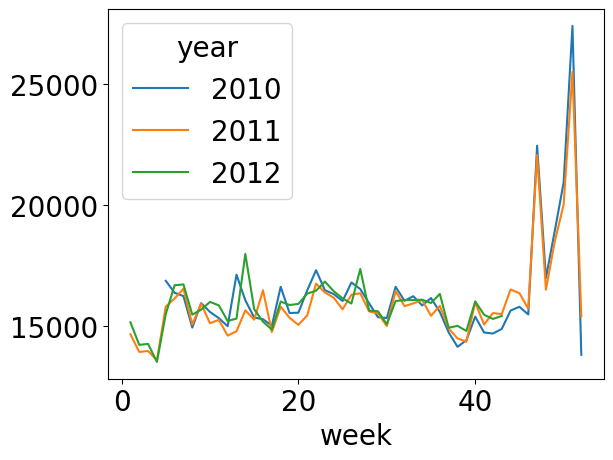

In [49]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

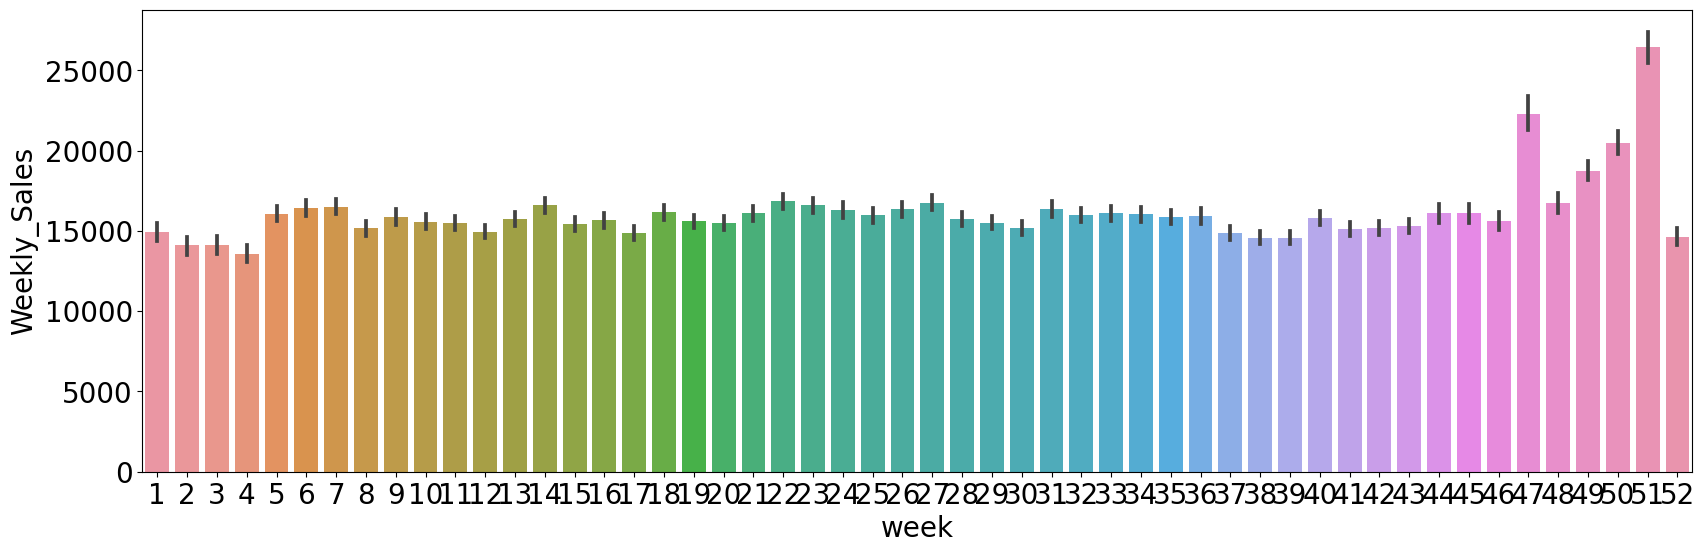

In [50]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

In [ ]:
'''
Из графиков видно, что 51-я и 47-я недели имеют значительно более высокие средние значения, 
как эффекты Рождества, Дня Благодарения и Черной пятницы.
'''

In [ ]:
'''
Цена на топливо, индекс потребительских цен, безработица, температурные эффекты
'''

<AxesSubplot:xlabel='Fuel_Price'>

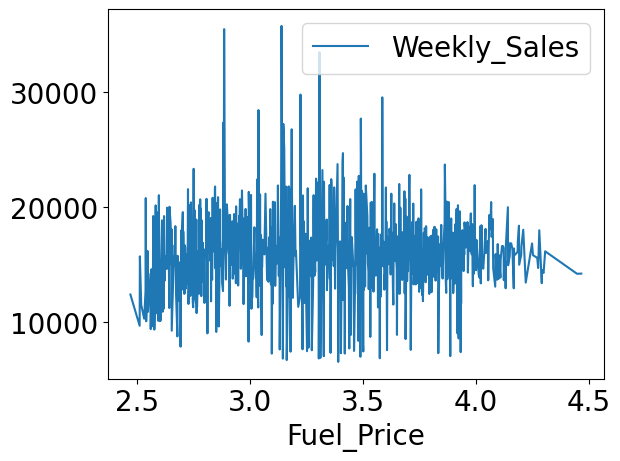

In [51]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

<AxesSubplot:xlabel='Temperature'>

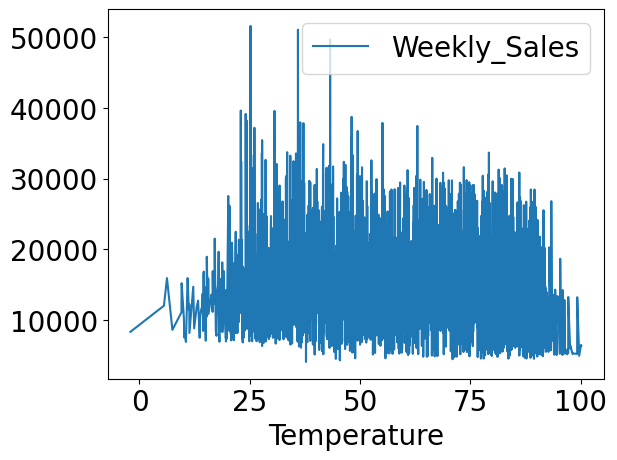

In [52]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()

<AxesSubplot:xlabel='CPI'>

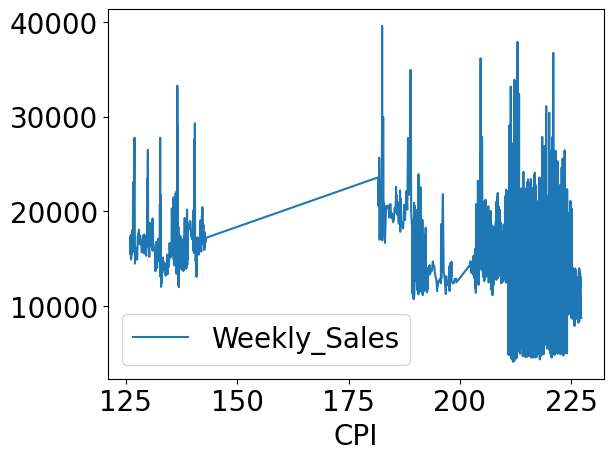

In [53]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot()

<AxesSubplot:xlabel='Unemployment'>

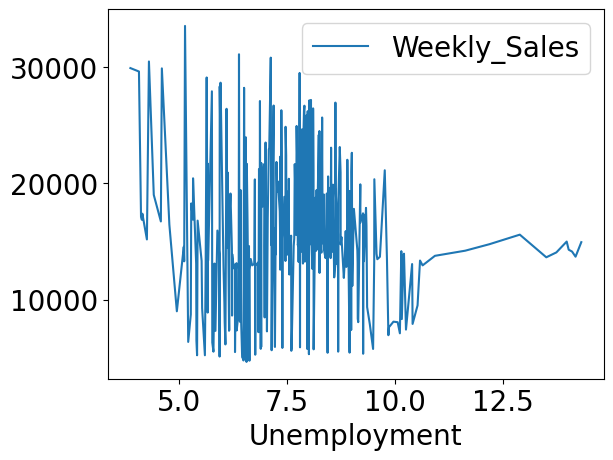

In [54]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()

In [ ]:
'''
Из графиков видно, что нет существенных закономерностей между индексом потребительских цен, температурой, уровнем безработицы, 
ценой на топливо и еженедельными продажами. Данных по индексу потребительских цен в диапазоне 140-180 также нет.
'''

In [55]:
# для использования назначаем новый датафрейм в csv

df.to_csv('clean_data.csv') 

In [ ]:
'''
В данных не так уж много пропущенных значений. Все столбцы проверены.
Выбираем строки, в которых еженедельные продажи выше 0. Минусовые значения составляют 0,3% данных. Отбрасываем.
Нулевые значения в уценках изменены на ноль. Потому что, они были записаны как нулевые, если на этом отделе не было уценки.
Исследования и открытия
По данным 45 магазинов и 81 отдел. Отделы не во всех магазинах одинаковые.
Хотя у отдела 72 более высокие показатели еженедельных продаж, в среднем отдел 92 является лучшим. 
Это показывает нам, что некоторые отделы имеют более высокие сезонные значения, например День Благодарения. 
Когда мы смотрим на 5 крупнейших продаж в данных, это неизменно: все они принадлежат 72-му отделу во время праздников 
в честь Дня Благодарения.
Хотя магазины 10 и 35 иногда имеют более высокие объемы еженедельных продаж, в среднем магазины 20 и 4 занимают первое 
и второе места. Это означает, что в некоторых регионах сезонные продажи выше.
Магазины имеют 3 типа: A, B и C в зависимости от их размеров. Почти половина магазинов имеют размер более 150 000 
и относятся к категории А. В зависимости от типа продажи магазинов меняются.
Как и ожидалось, средние продажи в праздничные дни выше, чем в обычные дни.
Рождественские каникулы представляют собой последние дни года. Но люди обычно делают покупки на 51-й неделе. 
Итак, когда мы смотрим на общий объем продаж в праздничные дни, продажи в День Благодарения между ними выше, 
что было установлено Walmart.
В 2010 году продажи выше, чем в 2011 и 2012 годах. Но продажи в ноябре и декабре не включены в данные за 2012 год. 
Даже без учета месяцев с наибольшими продажами 2012 год не намного меньше, чем 2010 год, поэтому, если добавить 
последние два месяца, он может быть первым.
Видно, что 51-я и 47-я недели имеют более высокие значения, а 50-48-я недели следуют за ними. 
Интересно, что 5-е место по объемам продаж приходится на 22-ю неделю года. Эти результаты показывают, 
что Рождество, День Благодарения и Черная пятница очень важны для продаж, чем другие недели, 
а пятое по важности время — 22-я неделя года, а это конец мая, когда школы закрыты. 
Скорее всего, люди готовятся к отдыху в конце мая.
Январские продажи значительно меньше, чем в другие месяцы. Это результат высоких продаж в ноябре и декабре. 
После двух месяцев высоких продаж люди предпочитают платить меньше в январе.
Индекс потребительских цен, температура, уровень безработицы и цены на топливо не влияют на еженедельные продажи.
Первое испытание со случайным лесом
В целом, Rondom Forest Regressor дает хорошие результаты, если его правильно настроить. 
Итак, чтобы найти простую базовую модель, я буду использовать в этом блокноте RandomForestRegressor. 

Наша метрика для этого проекта — средневзвешенная абсолютная ошибка (WMAE)

При использовании этого показателя ошибка в праздничные недели имеет вес в 5 раз больше, чем в обычные недели. 
Поэтому более важно точно спрогнозировать продажи в праздничные недели. 
Все результаты можно найти в конце этого блокнота.
'''

In [56]:
# Для предварительной обработки наших данных я изменю логические значения праздников на 0–1
# и заменю тип магазинов с A, B, C на 1, 2, 3.

# чтобы сохранить исходный фрейм данных, возьмем копию

df_encoded = df.copy()

# заменим A,B,C на 1-2-3

type_group = {'A':1, 'B': 2, 'C': 3}
df_encoded['Type'] = df_encoded['Type'].replace(type_group)

In [57]:
# заменим T,F на 0-1

df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int)

df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int)

df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int)

df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int)

df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int)

# берем копию df

df_new = df_encoded.copy()

In [ ]:
'''
Наблюдение взаимодействиq между объектами.
Удалим из своих данных разделенные столбцы праздников и попробуем обойтись без них. 
'''

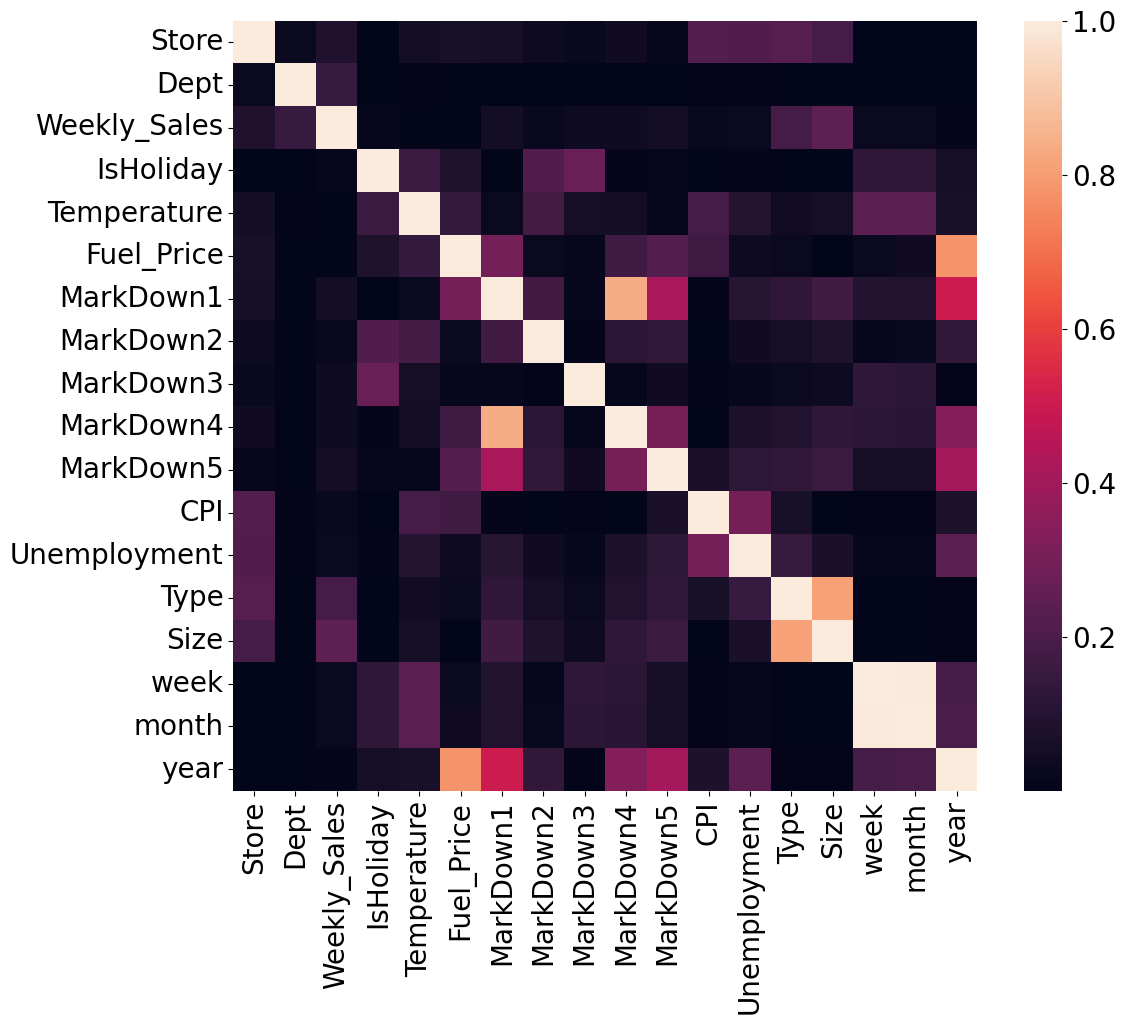

In [58]:
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']

# удалим колонки

df_new.drop(drop_col, axis=1, inplace=True) 

plt.figure(figsize = (12,10))

# Посмотрим корреляции
sns.heatmap(df_new.corr().abs())    
plt.show()

In [ ]:
'''
Температура, безработица, индекс потребительских цен не оказывают существенного влияния на недельные продажи, 
поэтому я их оставлю. Кроме того, Markdown 4 и 5 сильно коррелируют с Markdown 1. Поэтому я их тоже отброшу. 
Возможно, это создаст проблему мультиколлинеарности. Сначала попробуем без них.
'''

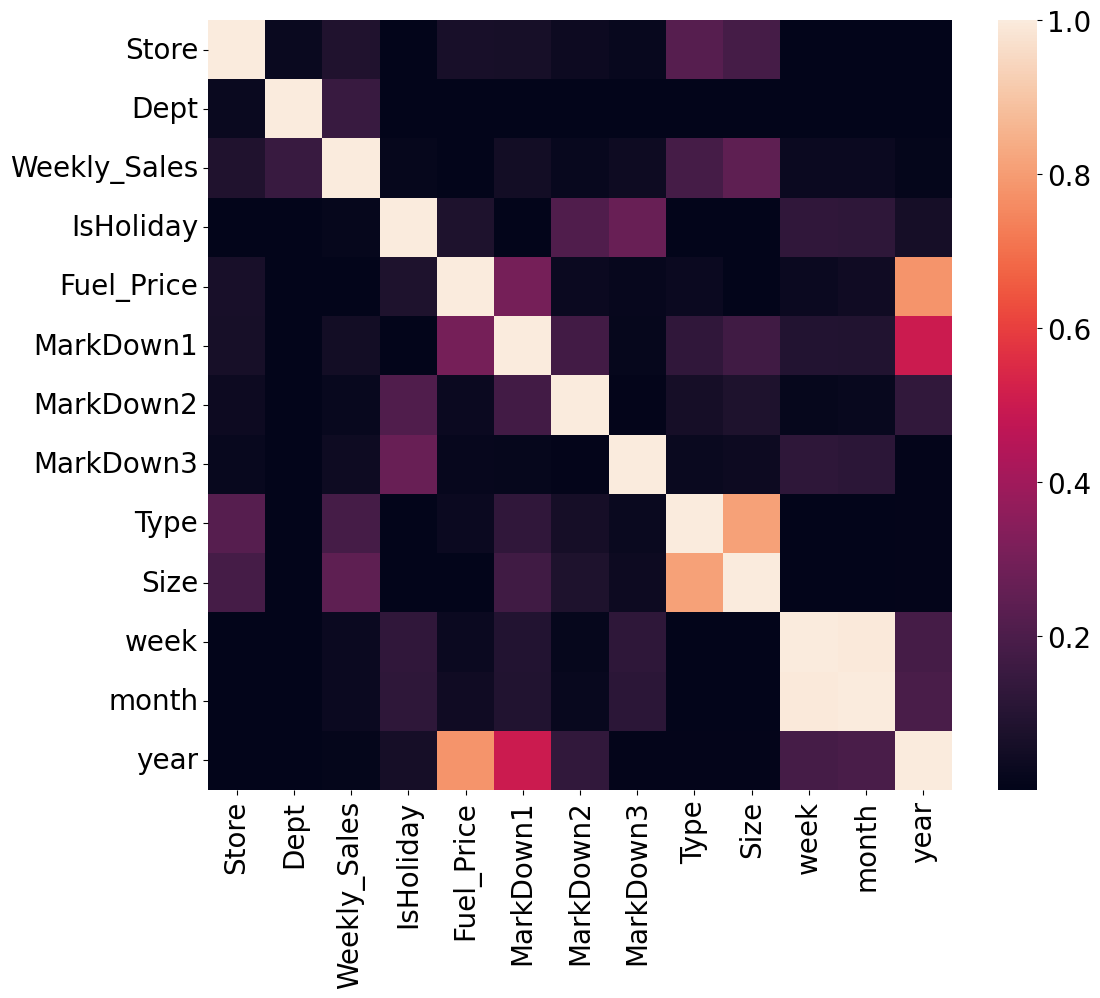

In [59]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True)

plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())
plt.show()

In [ ]:
'''
Размер и тип тесно связаны с еженедельными продажами. Также отдел и магазин коррелируют с продажами.
'''

In [60]:
# сортировка по дате

df_new = df_new.sort_values(by='Date', ascending=True) 

In [ ]:
'''
Создание трейн-тест сплитов.
Чтобы функции даты сохранялись, будем использовать случайное разбиение. Разделил данные вручную по 70%.
'''

In [61]:
train_data = df_new[:int(0.7*(len(df_new)))] # трейн
test_data = df_new[int(0.7*(len(df_new))):] # тест

# все столбцы, кроме еженедельных продаж
target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]]

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

# чтобы хранить значения X для обучения и тестирования

X = df_new[used_cols]

In [62]:
# У нас достаточно информации в нашей дате, например, о неделе года. Удаляю столбцы дат.

X_train = X_train.drop(['Date'], axis=1) # удаляем date из трейн
X_test = X_test.drop(['Date'], axis=1) # удаляем date из test

In [63]:
# Функция определения метрики
# Наша метрика не рассчитывается по умолчанию из готовых моделей.
# Это взвешенная ошибка, воспользуемся функцией, чтобы ее вычислить.

# WMAE для теста
def wmae_test(test, pred):  
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [ ]:
'''
Random Forest Regressor
Для настроийки регрессора, можно использовать поиск по сетке, но это занимает слишком много времени для данных такого типав. 
Выбираем параметры регрессора вручную. Каждый раз меняем параметры и стараемся найти лучший результ.
'''

In [64]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# создание pipe для совместного использования скаляра и регрессора

pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# предсказания на train
y_pred = pipe.predict(X_train)

# предсказания на test
y_pred_test = pipe.predict(X_test)

In [65]:
wmae_test(y_test, y_pred_test)

5850.444413125214

In [ ]:
'''
Для первого испытания взвешенная ошибка составляет около 5850.
'''

In [66]:
# увидеть важность признака

X = X.drop(['Date'], axis=1) # удалить date column из X

Feature ranking:
1. feature 1 (0.732822)
2. feature 8 (0.110390)
3. feature 0 (0.054027)
4. feature 7 (0.038210)
5. feature 9 (0.021277)
6. feature 3 (0.018402)
7. feature 10 (0.009446)
8. feature 6 (0.005523)
9. feature 4 (0.003413)
10. feature 5 (0.002776)
11. feature 2 (0.002246)
12. feature 11 (0.001467)


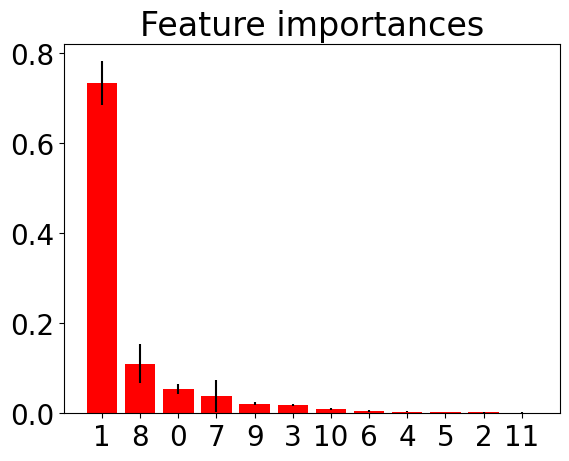

In [67]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Выводим feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Построим feature importances леса
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
'''
Посмотрев на важность функций, отбросим 3-4 наименее важных признаков и опробовуем модель. 
Нашел лучший результат, когда удалил столбец месяца, который сильно коррелирует с неделей.
'''

In [68]:
# удаляем месяц

X1_train = X_train.drop(['month'], axis=1) 
X1_test = X_test.drop(['month'], axis=1)

In [69]:
# Модель снова месяца

rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X1_train, y_train)

y_pred = pipe.predict(X1_train)

y_pred_test = pipe.predict(X1_test)

In [70]:
wmae_test(y_test, y_pred_test)

5494.419090545123

In [ ]:
'''
Это дает лучшие результаты, чем базовый уровень.
'''

In [ ]:
'''
Модель с целыми данными
Убедимся, что модель будет учиться на столбцах, которые удалиленных или нет. 
Применим модель ко всем закодированным данным.
'''

In [71]:
train_data_enc = df_encoded[:int(0.7*(len(df_encoded)))]
test_data_enc = df_encoded[int(0.7*(len(df_encoded))):]

target = "Weekly_Sales"
used_cols1 = [c for c in df_encoded.columns.to_list() if c not in [target]] # все столбцы, кроме цены

X_train_enc = train_data_enc[used_cols1]
X_test_enc = test_data_enc[used_cols1]
y_train_enc = train_data_enc[target]
y_test_enc = test_data_enc[target]

X_enc = df_encoded[used_cols1] 

X_enc = X_enc.drop(['Date'], axis=1) # удаление столбца даты для всего X

In [72]:
X_train_enc = X_train_enc.drop(['Date'], axis=1) 
X_test_enc= X_test_enc.drop(['Date'], axis=1)

rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc, y_train_enc)

# предсказания по train set
y_pred_enc = pipe.predict(X_train_enc)

# предсказания по test set
y_pred_test_enc = pipe.predict(X_test_enc)

wmae_test(y_test_enc, y_pred_test_enc)

2450.1012493925496

In [ ]:
'''
Мы нашли лучшие результаты для целых данных, это означает, что наша модель может учиться на столбцах, которые удалены ранее.
'''

In [ ]:
'''
Важность признаков для всего закодированного датасета
'''

Feature ranking:
1. feature 1 (0.743136)
2. feature 13 (0.075801)
3. feature 12 (0.043810)
4. feature 0 (0.031172)
5. feature 10 (0.028007)
6. feature 11 (0.017039)
7. feature 18 (0.012315)
8. feature 3 (0.011079)
9. feature 4 (0.009879)
10. feature 19 (0.005534)
11. feature 7 (0.004481)
12. feature 9 (0.003979)
13. feature 5 (0.003461)
14. feature 8 (0.003315)
15. feature 6 (0.002381)
16. feature 16 (0.001363)
17. feature 20 (0.001200)
18. feature 2 (0.000879)
19. feature 17 (0.000597)
20. feature 14 (0.000290)
21. feature 15 (0.000283)


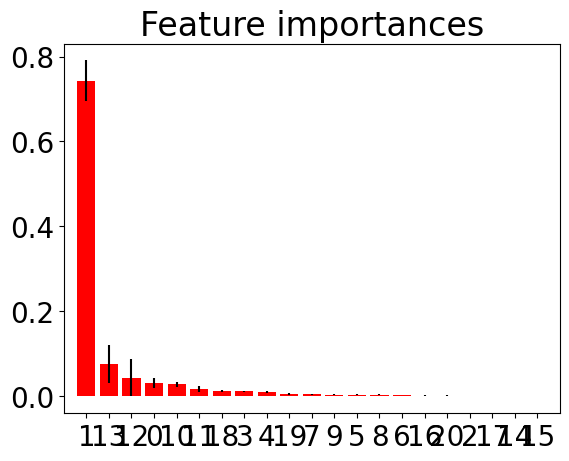

In [73]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Выводим feature ranking
print("Feature ranking:")

for f in range(X_enc.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Строим feature importances леса
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_enc.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_enc.shape[1]), indices)
plt.xlim([-1, X_enc.shape[1]])
plt.show()

In [ ]:
'''
В зависимости от важности признаковя удалим несколько столбцов из всего набора и снова попробуем модель.
'''

In [76]:
df_encoded_new = df_encoded.copy()
df_encoded_new.drop(drop_col, axis=1, inplace=True)

In [77]:
# Модель в соответствии с важностью Признаков

train_data_enc_new = df_encoded_new[:int(0.7*(len(df_encoded_new)))]
test_data_enc_new = df_encoded_new[int(0.7*(len(df_encoded_new))):]

target = "Weekly_Sales"
used_cols2 = [c for c in df_encoded_new.columns.to_list() if c not in [target]] # все столбцы, кроме цены

X_train_enc1 = train_data_enc_new[used_cols2]
X_test_enc1 = test_data_enc_new[used_cols2]
y_train_enc1 = train_data_enc_new[target]
y_test_enc1 = test_data_enc_new[target]

# удалим данные из train-test
X_train_enc1 = X_train_enc1.drop(['Date'], axis=1)
X_test_enc1= X_test_enc1.drop(['Date'], axis=1)

rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=40,
                           max_features = 'log2',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc1, y_train_enc1)

# предсказание train set
y_pred_enc = pipe.predict(X_train_enc1)

# предсказание test set
y_pred_test_enc = pipe.predict(X_test_enc1)

pipe.score(X_test_enc1,y_test_enc1)

0.7397036882771106

In [78]:
wmae_test(y_test_enc1, y_pred_test_enc)

1801.5211888667177

In [ ]:
'''
Наилучшие результаты получены при выборе функций из всего закодированного набора данных.
'''

In [ ]:
'''
Модель с удаленным столбцом месяца.

Используя тот же набор данных, что и раньше, пытаемся снова смоделировать без столбца месяца.
'''

In [79]:
df_encoded_new1 = df_encoded.copy()
df_encoded_new1.drop(drop_col, axis=1, inplace=True)

df_encoded_new1 = df_encoded_new1.drop(['Date'], axis=1)

df_encoded_new1 = df_encoded_new1.drop(['month'], axis=1)

train_data_enc_new1 = df_encoded_new1[:int(0.7*(len(df_encoded_new1)))]
test_data_enc_new1 = df_encoded_new1[int(0.7*(len(df_encoded_new1))):]

target = "Weekly_Sales"
used_cols3 = [c for c in df_encoded_new1.columns.to_list() if c not in [target]]

X_train_enc2 = train_data_enc_new1[used_cols3]
X_test_enc2 = test_data_enc_new1[used_cols3]
y_train_enc2 = train_data_enc_new1[target]
y_test_enc2 = test_data_enc_new1[target]

# моделирование
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc2, y_train_enc2)

y_pred_enc = pipe.predict(X_train_enc2)
y_pred_test_enc = pipe.predict(X_test_enc2)

In [80]:
pipe.score(X_test_enc2,y_test_enc2)

0.7040151411780626

In [81]:
wmae_test(y_test_enc2, y_pred_test_enc)

2093.074731200826

In [ ]:
'''
Это не дало лучших результатов, чем раньше.
'''

In [82]:
# df_result для совместного отображения результатов

df_results = pd.DataFrame(columns=["Model", "Info",'WMAE'])

In [83]:
# запись результатов в df

df_results = df_results.append({     
     "Model": 'RandomForestRegressor' ,
      "Info": 'w/out divided holiday columns' , 
       'WMAE' : 5850}, ignore_index=True)
df_results = df_results.append({     
     "Model": 'RandomForestRegressor' ,
      "Info": 'w/out month column' , 
       'WMAE' : 5494}, ignore_index=True)
df_results = df_results.append({     
     "Model": 'RandomForestRegressor' ,
      "Info": 'whole data' , 
       'WMAE' : 2450}, ignore_index=True)
df_results = df_results.append({     
     "Model": 'RandomForestRegressor' ,
      "Info": 'whole data with feature selection' , 
       'WMAE' : 1801}, ignore_index=True)
df_results = df_results.append({     
     "Model": 'RandomForestRegressor' ,
      "Info": 'whole data with feature selection w/out month' , 
       'WMAE' : 2093}, ignore_index=True)

df_results

,Model,Info,WMAE
0,RandomForestRegressor,w/out divided holiday columns,5850
1,RandomForestRegressor,w/out month column,5494
2,RandomForestRegressor,whole data,2450
3,RandomForestRegressor,whole data with feature selection,1801
4,RandomForestRegressor,whole data with feature selection w/out month,2093


In [ ]:
'''
Time Series Models
Наилучшие результаты принадлежат всему набору данных с выбором признаков. Теперь попробуем модели временных рядов.
'''

In [84]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420212 entries, 0 to 421569
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         420212 non-null  int64         
 1   Dept          420212 non-null  int64         
 2   Date          420212 non-null  datetime64[ns]
 3   Weekly_Sales  420212 non-null  float64       
 4   IsHoliday     420212 non-null  bool          
 5   Temperature   420212 non-null  float64       
 6   Fuel_Price    420212 non-null  float64       
 7   MarkDown1     420212 non-null  float64       
 8   MarkDown2     420212 non-null  float64       
 9   MarkDown3     420212 non-null  float64       
 10  MarkDown4     420212 non-null  float64       
 11  MarkDown5     420212 non-null  float64       
 12  CPI           420212 non-null  float64       
 13  Unemployment  420212 non-null  float64       
 14  Type          420212 non-null  object        
 15  Size          420

In [86]:
# изменение данных на datetime для декомпозинга

df["Date"] = pd.to_datetime(df["Date"]) 

# используем дату как индекс

df.set_index('Date', inplace=True) 

df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,1,2,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,1,3,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,1,4,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,1,5,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010


In [ ]:
'''
График продаж
'''

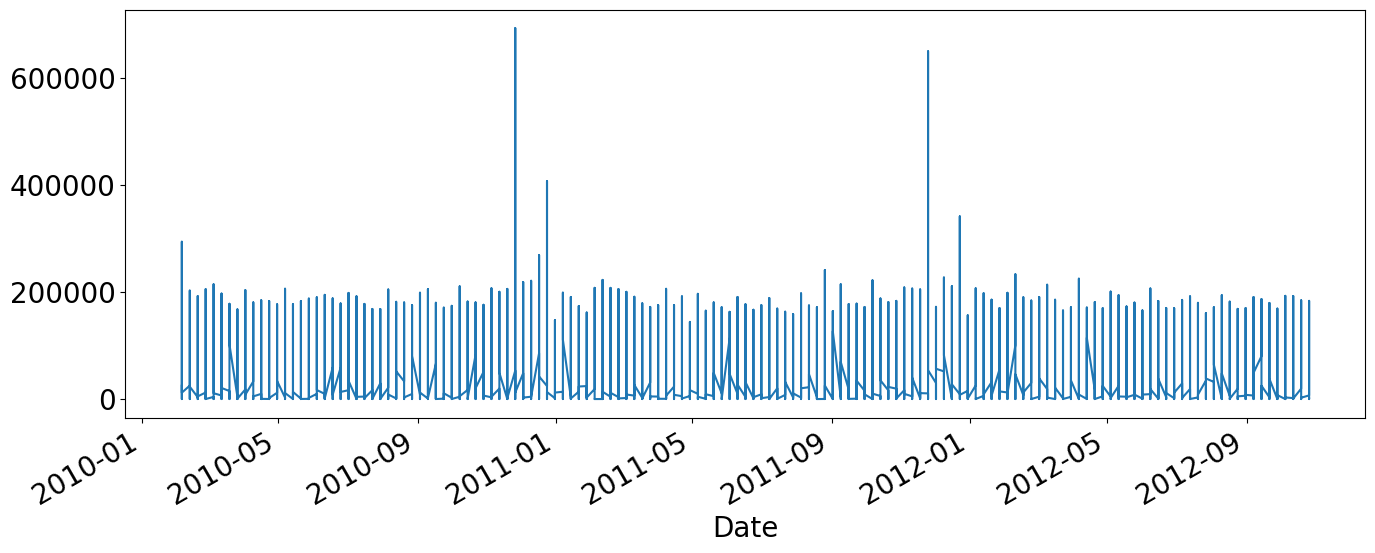

In [87]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()

In [ ]:
'''
В этих данных есть много одинаковых значений данных. Соберем их вместе еженедельно.
'''

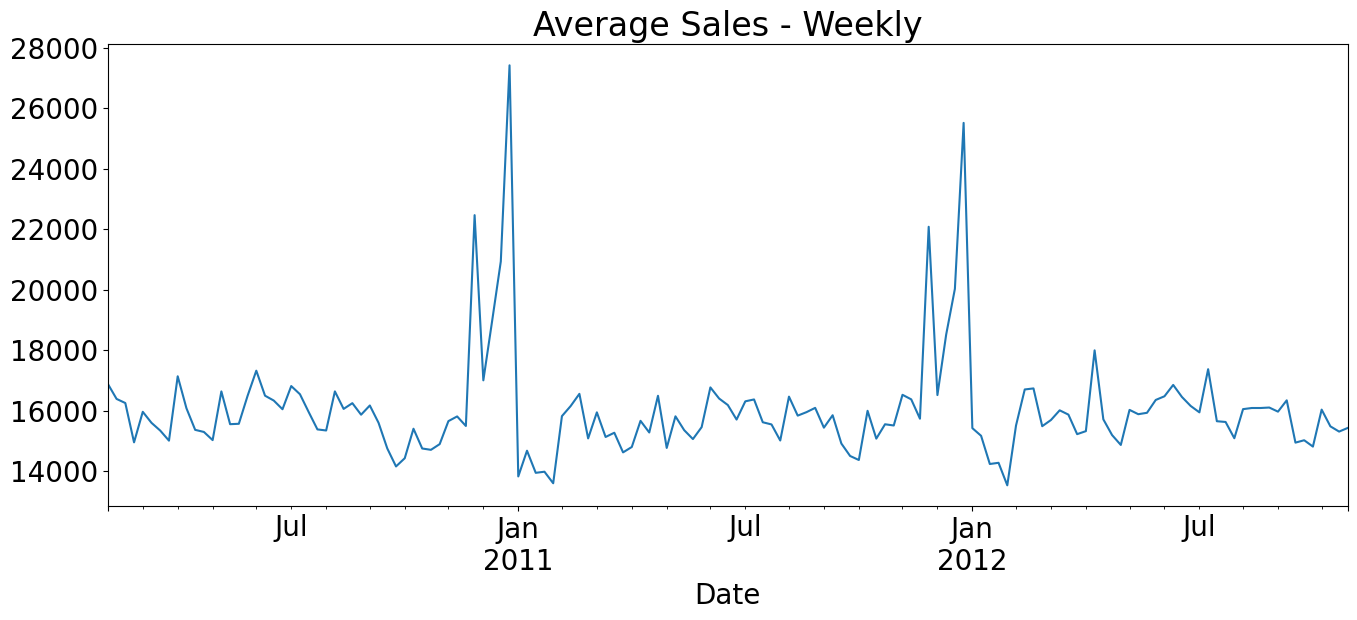

In [88]:
df_week = df.resample('W').mean()

plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

In [ ]:
'''
Поскольку данные собираются еженедельно, можно четко видеть средние продажи. 
Чтобы увидеть помесячную динамику, изменим выборку данных на ежемесячные.
'''

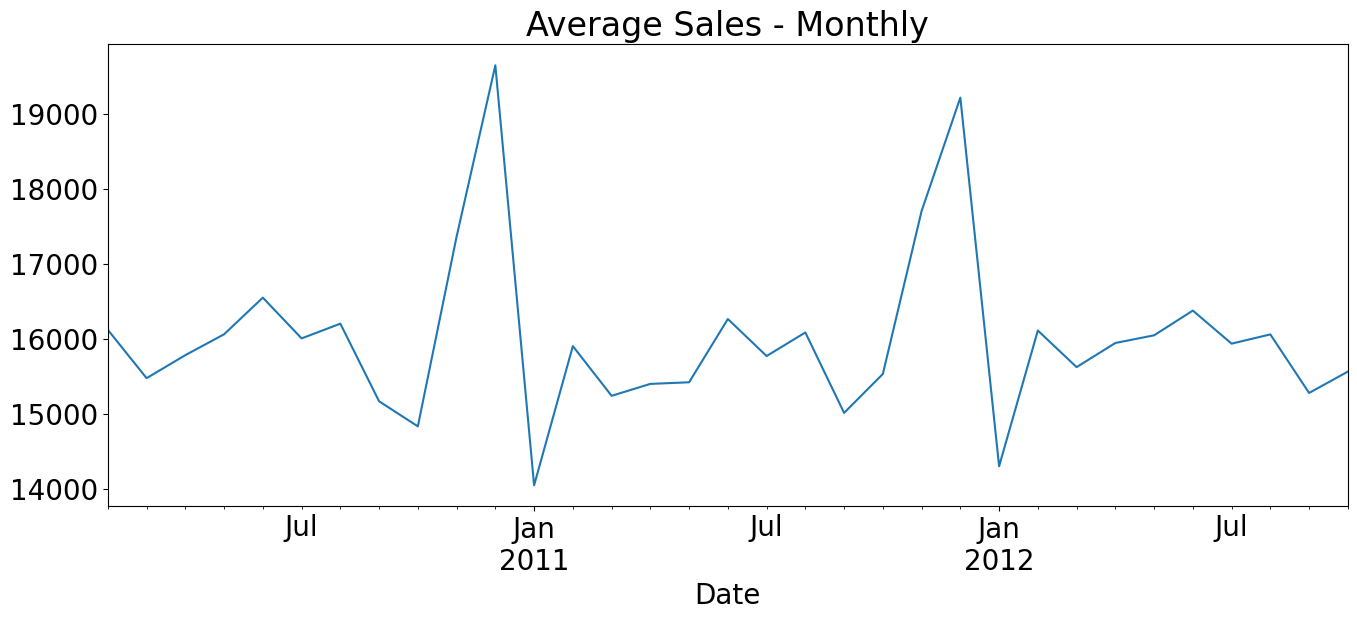

In [89]:
df_month = df.resample('MS').mean()

plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

In [ ]:
'''
Когда мы перевели данные на ежемесячные, потеряли некоторые закономерности в еженедельных данных. 
Продолжим работу с еженедельно обновляемыми данными.
'''

In [ ]:
'''
Наблюдения за 2-недельным Rolling Mean и Std
Данные нестационарны. Попробую найти более стационарную версию.
'''

In [92]:
# находим 2-недельные rolling mean и std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

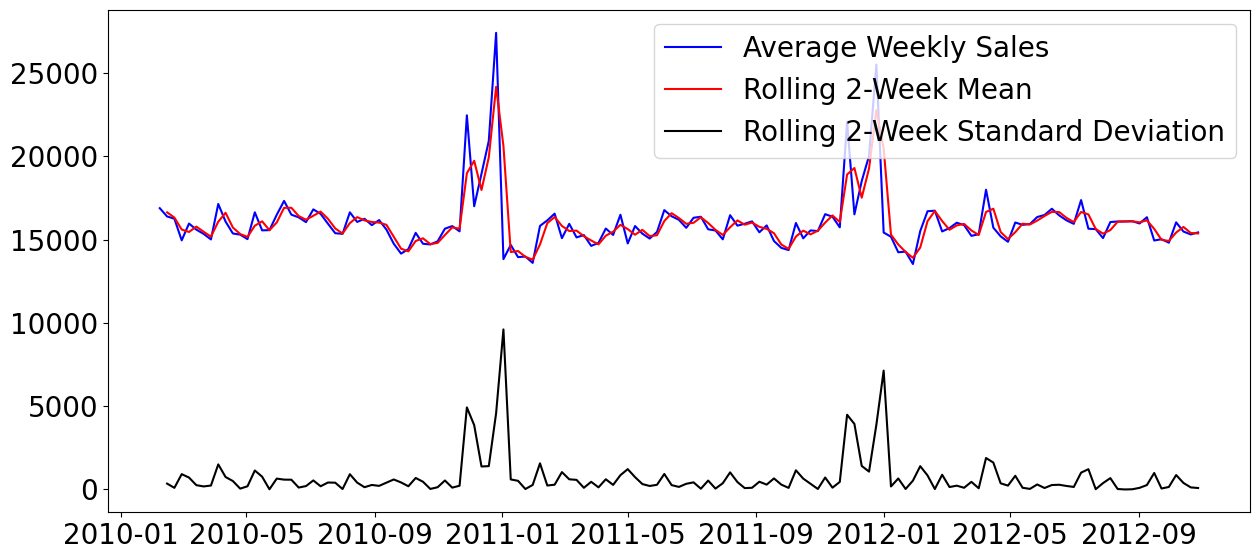

In [93]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

In [ ]:
'''
Тест Адфуллера, чтобы убедиться
'''

In [94]:
adfuller(df_week['Weekly_Sales'])

(-5.927107223737568,
 2.429049208204276e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

In [ ]:
'''
Судя по тестам и наблюдениям,  данные не стационарны. Постараемся найти более стационарную версию.

Train - Test Split еженедельных данных
Чтобы выполнить train-test splits непрерывно, разделим его вручную, а не случайным образом.
'''

In [95]:
train_data = df_week[:int(0.7*(len(df_week)))] 
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 21)
Test: (43, 21)


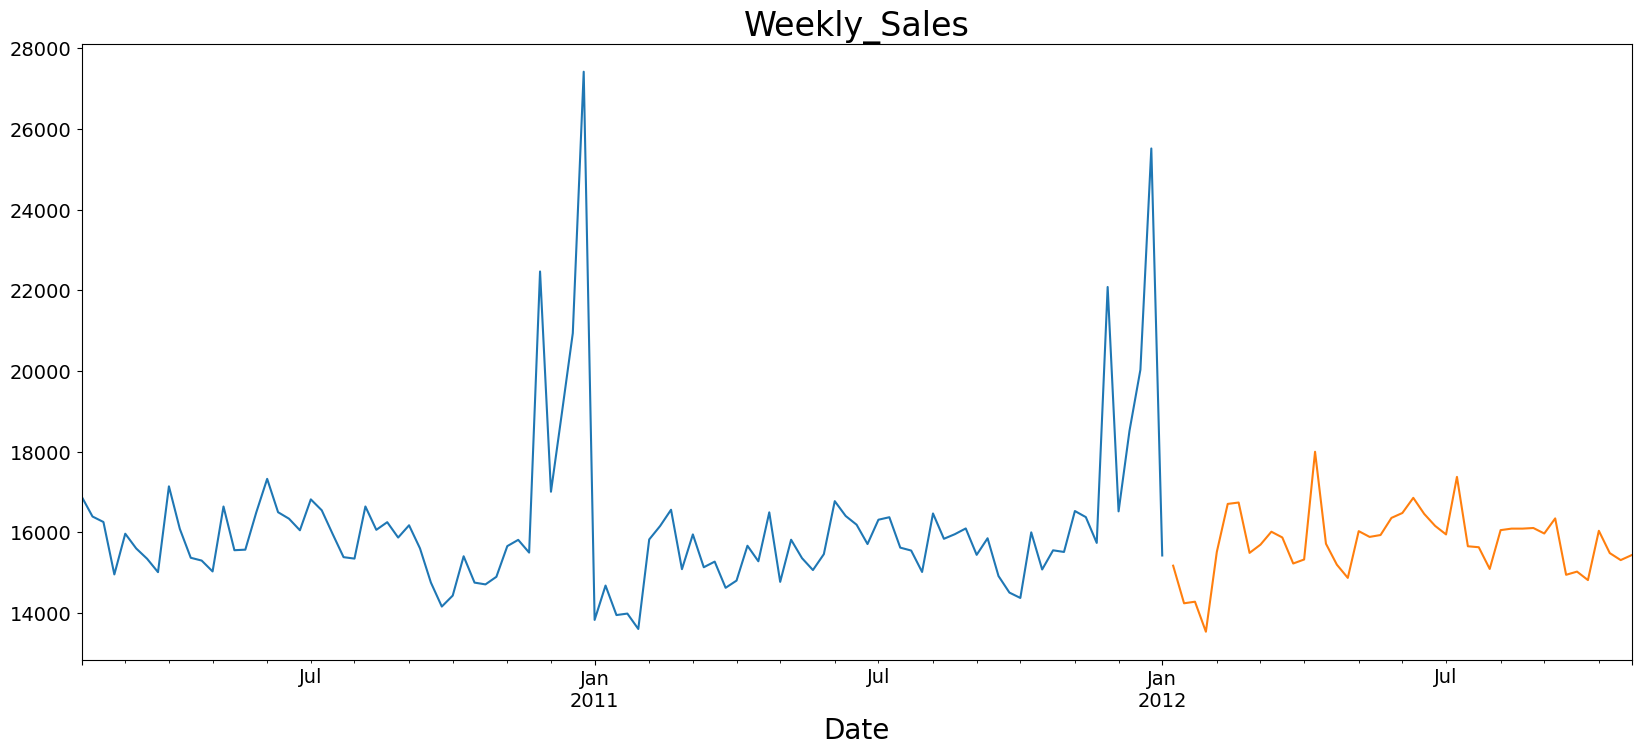

In [96]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

In [ ]:
'''
Синяя линия представляет train_data, желтая — test_data.
'''

In [ ]:
'''
Разложение Weekly Data для наблюдения за сезонностью
'''

In [97]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20)

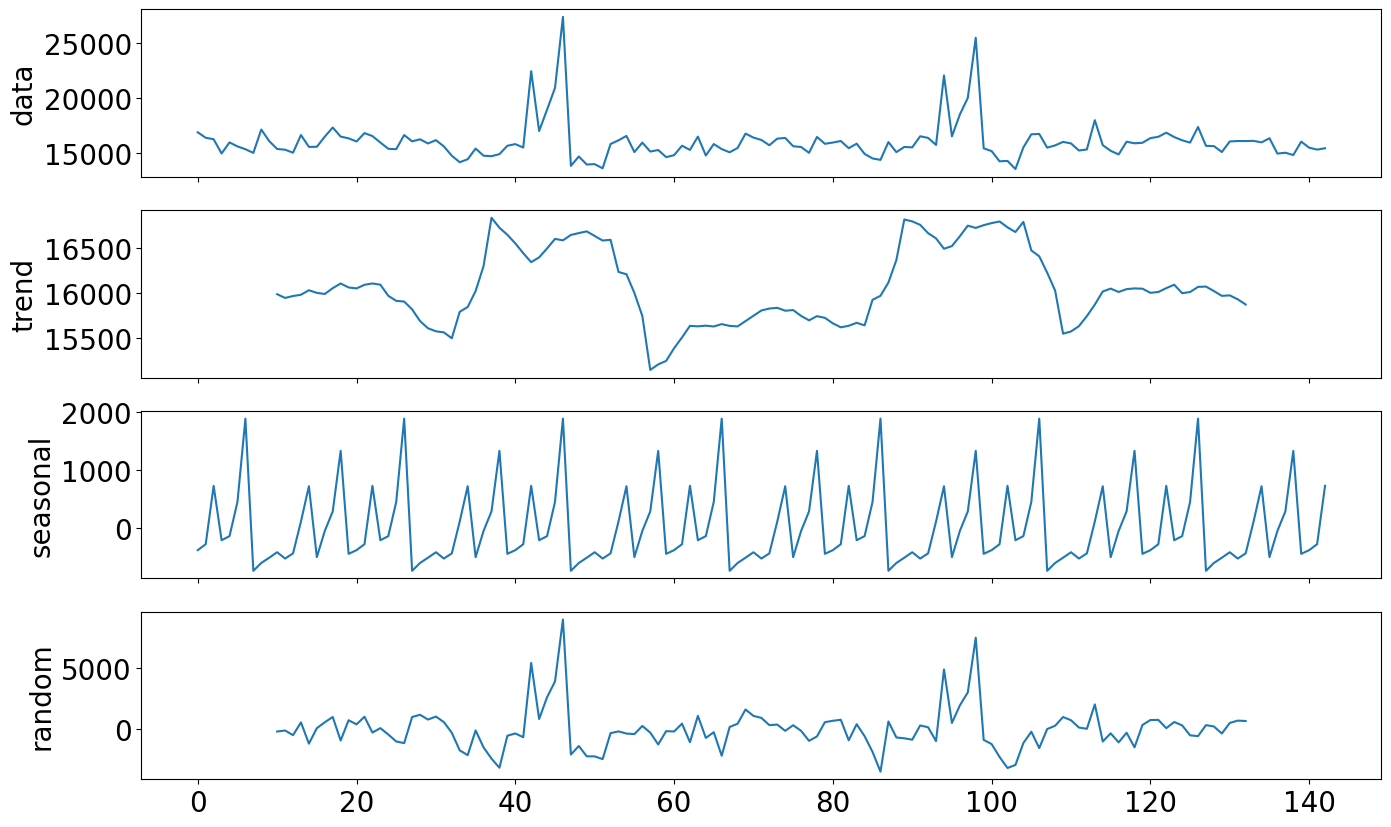

In [98]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

In [ ]:
'''
Судя по графикам выше, каждые 20 шагов сезонности сходятся к начальной точке. Это поможет мне настроить модель.
'''

In [ ]:
'''
Попытка сделать данные более стационарными
Теперь постараемся сделать данные более стационарными. 
Для этого попробуем модель с differenced, logged и shifted данными.

1. Difference
'''

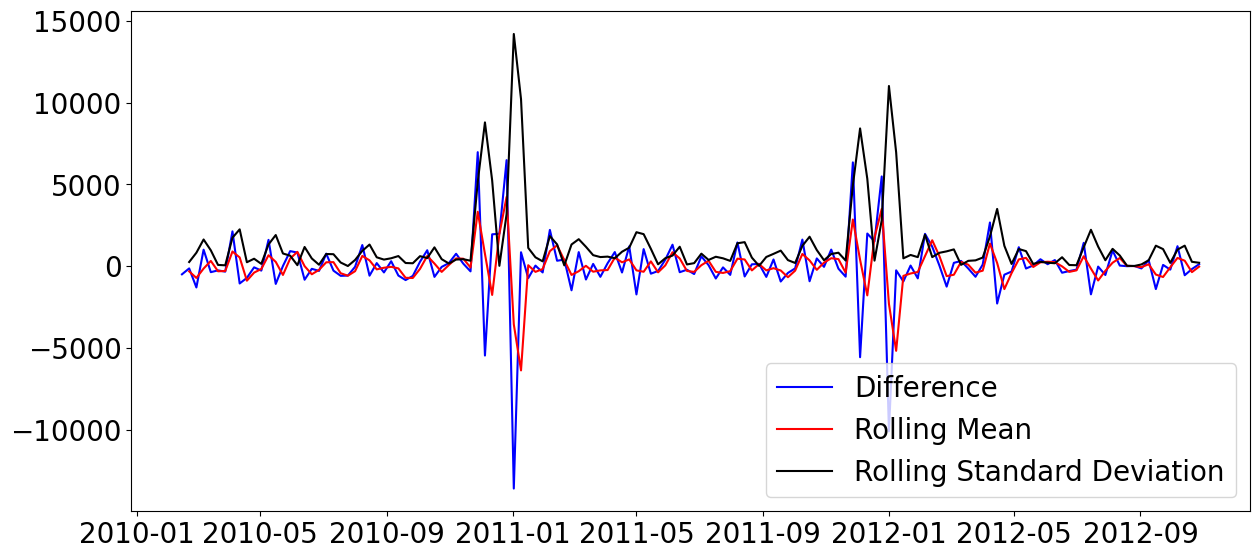

In [99]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna()

diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

In [ ]:
'''
2.Shift
'''

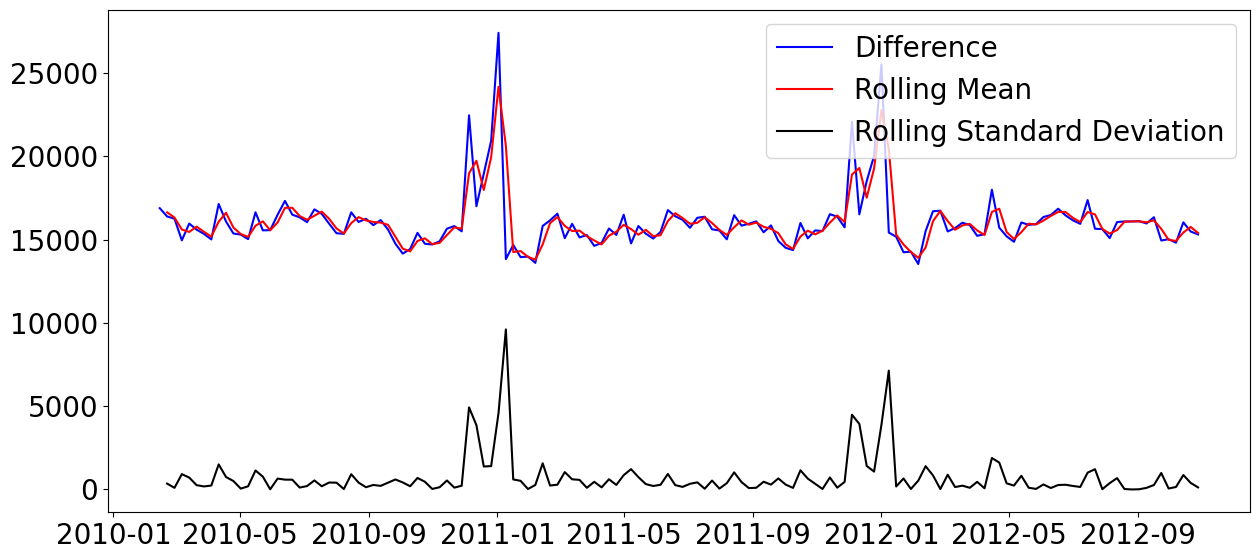

In [100]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna()

lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean() 
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

In [ ]:
'''
3.Log
'''

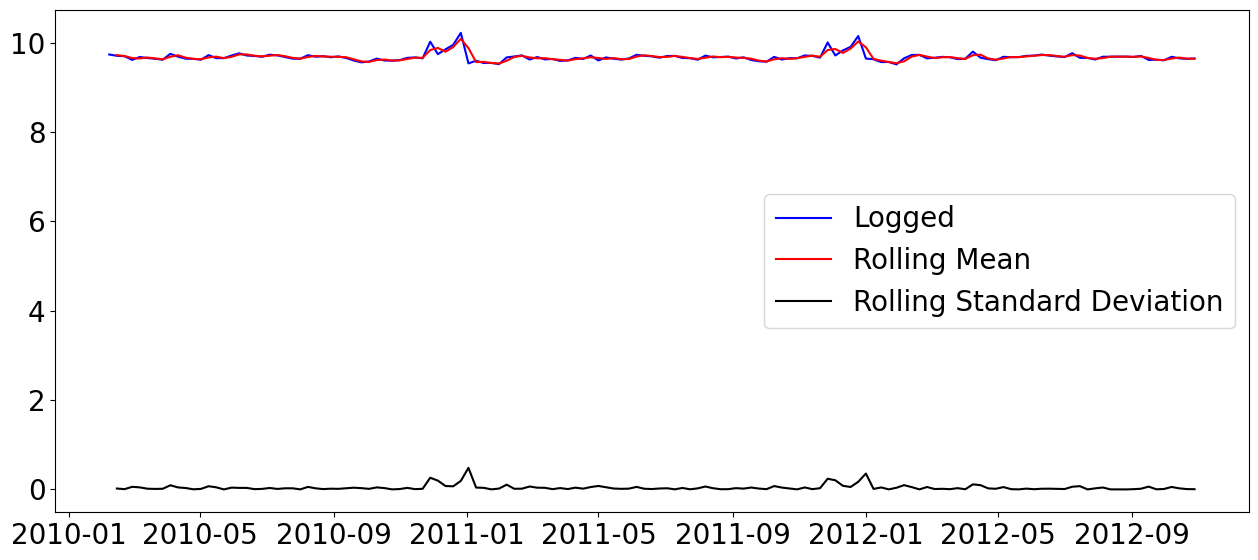

In [101]:
logged_week = np.log1p(df_week['Weekly_Sales']).dropna()

log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

In [ ]:
'''
Auto-ARIMA MODEL

Попробовал свои данные без каких-либо изменений, затем попробовал сдвинуть, взять журнал и разностную версию данных. 
Разные данные дали лучшие результаты. Возьмем разницу и используем эти данные.

Train-Test Split
'''

In [102]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.80 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.34 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

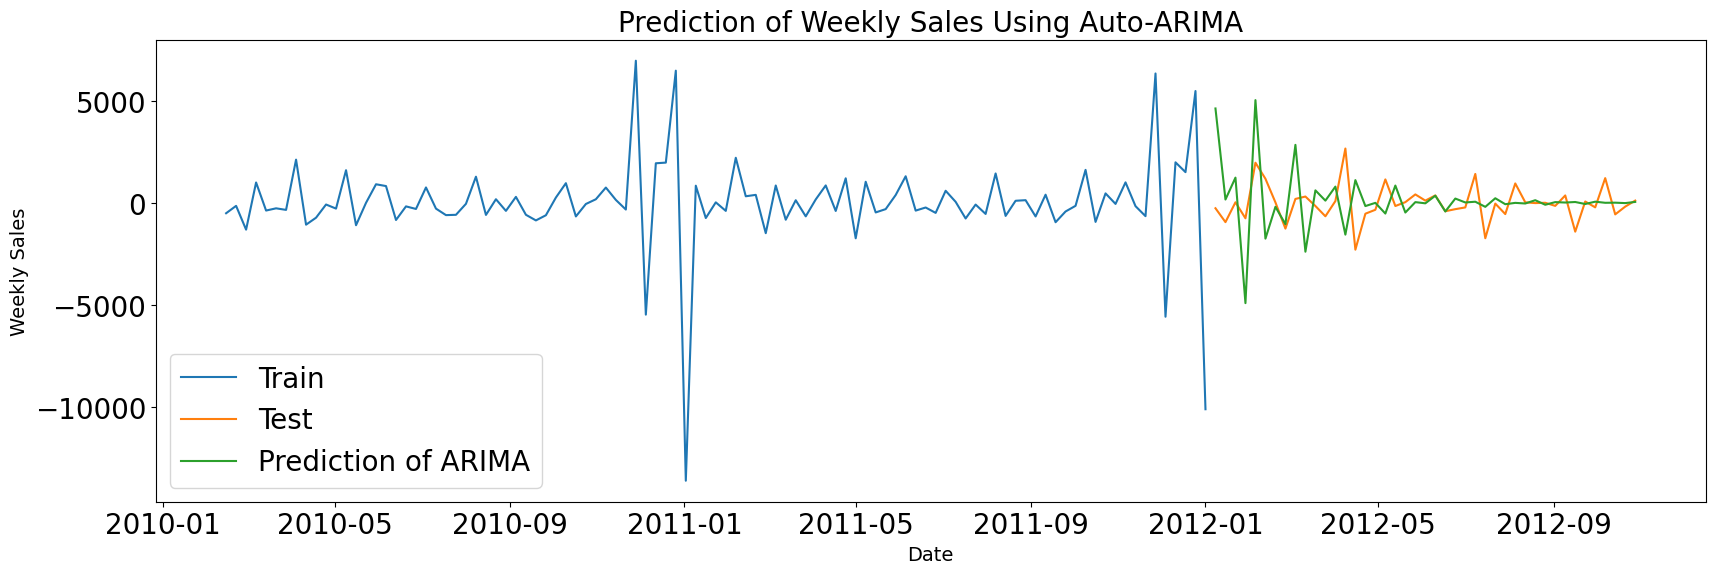

In [103]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [ ]:
'''
Мне не нравится шаблон прогнозов, поэтому я решил попробовать другую модель.
'''

In [ ]:
'''
Экспоненциальное сглаживание
Подходящие модели Holt-Winters я проверил по своим данным. 
Экспоненциальное сглаживание используется, когда данные имеют тенденцию и выравнивают тенденцию. 
Метод затухающего тренда добавляет параметр демпфирования, поэтому в будущем тренд сходится к постоянному значению.

Мои данные о разнице имеют некоторые минусовые и нулевые значения, поэтому я использовал аддитивные сезонные 
и трендовые значения вместо мультипликативных. 
Сезонные периоды выбираются из разложенных графиков выше. 
Настройка модели с итерациями занимает слишком много времени, поэтому я изменил и попробовал модель для разных параметров, 
нашел лучшие параметры и подогнал их к модели.
'''

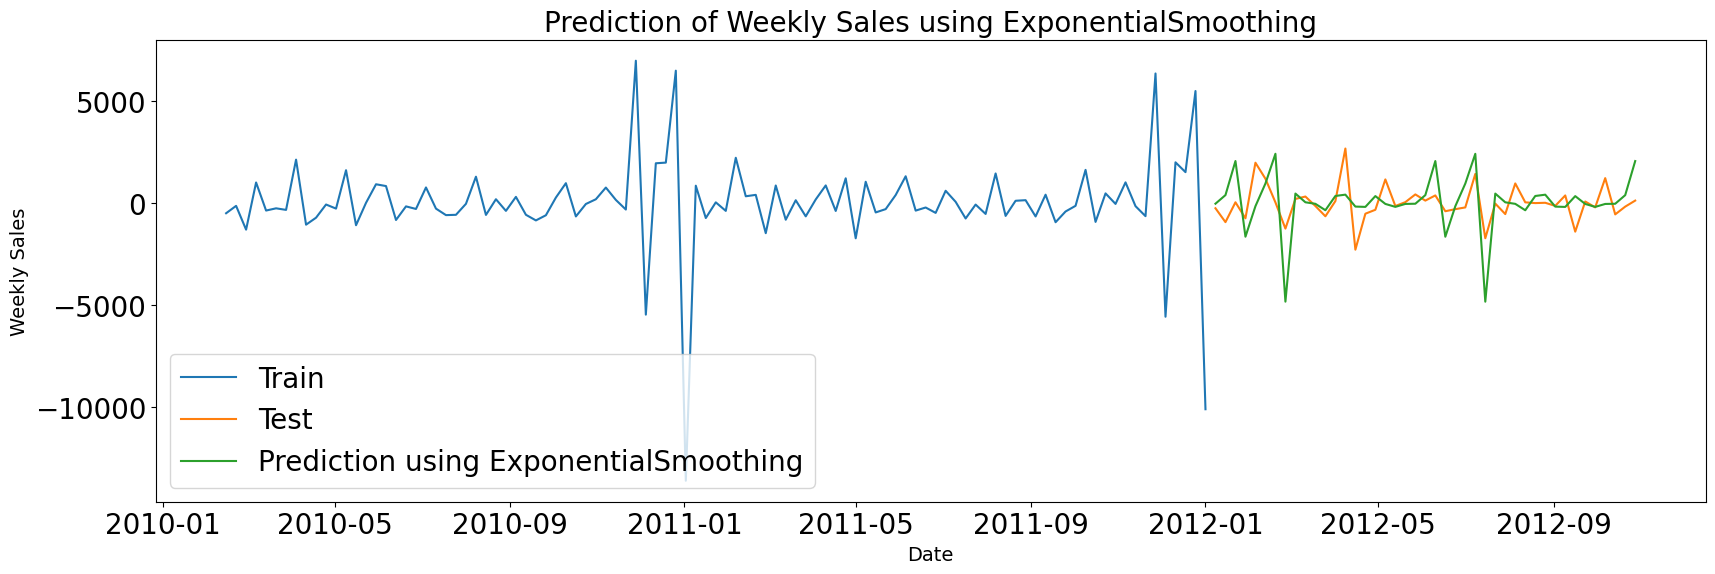

In [104]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() # Учитывая аддитивную тенденцию и сезонность.
y_pred = model_holt_winters.forecast(len(test_data_diff)) # Предсказания test data

# Визуализация train, test и predicted данных.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [105]:
wmae_test(test_data_diff, y_pred)

840.681060966696

In [ ]:
'''
Мы нашли лучшие результаты для своих данных с помощью модели экспоненциального сглаживания.

Лучший результат для этого проекта — 821. Судя по объемам продаж, это значение составляет примерно 4-5% погрешности. 
Если мы возьмем наши средние продажи и возьмем процент от 821 ошибки, это составит примерно 4-5%.
'''